In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [184]:
covid = pd.read_csv('covid.csv')
covid['Date'] = covid['Date'].astype('datetime64')
covid.head()

,Date,Zone,New_Confirmed
0,2020-03-06,Calgary,1
1,2020-03-06,Edmonton,0
2,2020-03-07,Calgary,1
3,2020-03-07,Edmonton,0
4,2020-03-08,Calgary,1


In [185]:
covid.columns

Index(['Date', 'Zone', 'New_Confirmed'], dtype='object')

In [186]:
covid['cumsum'] = covid.groupby(['Zone']).cumsum()
covid

,Date,Zone,New_Confirmed,cumsum
0,2020-03-06,Calgary,1,1
1,2020-03-06,Edmonton,0,0
2,2020-03-07,Calgary,1,2
3,2020-03-07,Edmonton,0,0
4,2020-03-08,Calgary,1,3
...,...,...,...,...
64,2020-03-25,Calgary,49,282
65,2020-03-25,Central,3,36
66,2020-03-25,Edmonton,18,109
67,2020-03-25,North,2,23


In [187]:
totals = pd.DataFrame(list(covid.groupby(['Date']).groups.keys()), columns=['Date'])
totals = totals.astype('datetime64')
totals.insert(1,'New_Confirmed', covid.groupby(['Date'])['New_Confirmed'].sum().values)
totals.sort_values(by='Date', inplace=True)
totals.reset_index(inplace=True, drop=True)
totals['cumsum'] = totals['New_Confirmed'].cumsum(axis=0)
totals

,Date,New_Confirmed,cumsum
0,2020-03-06,1,1
1,2020-03-07,1,2
2,2020-03-08,3,5
3,2020-03-09,1,6
4,2020-03-10,6,12
5,2020-03-11,7,19
6,2020-03-12,1,20
7,2020-03-13,10,30
8,2020-03-14,19,49
9,2020-03-15,11,60


In [197]:
covid['inc33'] = 0
covid['dtime'] = 0
covid['dtime_rw'] = 0
for grps in covid.groupby(['Zone']).groups.keys():
    gdata = covid.groupby(['Zone']).get_group(grps)
    startCases = gdata.iloc[0]['cumsum']
    for idx in range(1, len(gdata)):
        bidx = idx - 1
        increase33 = int(np.ceil(gdata.iloc[bidx]['cumsum'] * 1.33))
        dfIdx = gdata.iloc[idx].name
        covid.loc[dfIdx, 'inc33'] = increase33
        
        # Doubling time
         
        nNewCases = gdata.iloc[idx]['cumsum']
        newDate = gdata.iloc[idx]['Date']
        nOldCases = gdata.iloc[bidx]['cumsum']
        if nOldCases == 0:
            startCases = nNewCases
            startDate = newDate
        if nOldCases >= 1 :
            tdelta = newDate - startDate
            dtime = ( tdelta.days * np.log(2) ) / ( np.log(nNewCases / startCases))
            if dtime < 0: dtime = 0
            covid.loc[dfIdx, 'dtime'] = dtime 
        # Rolling window calculation
        if idx >= 6:
            rwIdx = idx - 6
            nOldCasesRW = gdata.iloc[rwIdx]['cumsum']
            oldDateRW = gdata.iloc[rwIdx]['Date']
            if nOldCasesRW > 0:
                tdeltaRW = newDate - oldDateRW
                dtimeRW = ( tdeltaRW.days * np.log(2) ) / ( np.log(nNewCases / nOldCasesRW))
                if dtimeRW < 0: dtimeRW = 0
                covid.loc[dfIdx, 'dtime_rw'] = dtimeRW 

<ipython-input-197-b760db5b98ff>:23: RuntimeWarning: divide by zero encountered in double_scalars
  dtime = ( tdelta.days * np.log(2) ) / ( np.log(nNewCases / startCases))


In [198]:
covid

,Date,Zone,New_Confirmed,cumsum,inc33,dtime,dtime_rw
0,2020-03-06,Calgary,1,1,0,0.000000,0.000000
1,2020-03-06,Edmonton,0,0,0,0.000000,0.000000
2,2020-03-07,Calgary,1,2,2,0.000000,0.000000
3,2020-03-07,Edmonton,0,0,0,0.000000,0.000000
4,2020-03-08,Calgary,1,3,3,0.000000,0.000000
...,...,...,...,...,...,...,...
64,2020-03-25,Calgary,49,282,310,2.088567,4.129243
65,2020-03-25,Central,3,36,44,3.288249,1.892789
66,2020-03-25,Edmonton,18,109,122,2.947201,3.849285
67,2020-03-25,North,2,23,28,4.824663,6.392503


In [190]:
totals['inc33'] = 0
totals['dtime'] = 0
covid['dtime_rw'] = 0
for idx in range(1, len(totals)):
    bidx = idx - 1
    increase33 = int(np.ceil(totals.loc[bidx, 'cumsum'] * 1.33))
    totals.loc[idx, 'inc33'] = increase33
    if idx > 5:
        oldIdx = idx - 6
        nOldCases = totals.loc[oldIdx, 'cumsum']
        oldDate = totals.loc[oldIdx, 'Date']
        if nOldCases > 0:
            nNewCases = totals.loc[idx, 'cumsum']
            newDate = totals.loc[idx, 'Date']
            tdelta = newDate - oldDate
            dtime = ( tdelta.days * np.log(2) ) / ( np.log(nNewCases / nOldCases))
        totals.loc[idx, 'dtime_rw'] = dtime 


In [191]:
covid.groupby(['Zone']).get_group('Edmonton')

,Date,Zone,New_Confirmed,cumsum,inc33,dtime,dtime_rw
1,2020-03-06,Edmonton,0,0,0,0.000000,0
3,2020-03-07,Edmonton,0,0,0,0.000000,0
5,2020-03-08,Edmonton,2,2,0,0.000000,0
7,2020-03-09,Edmonton,0,2,3,inf,0
9,2020-03-10,Edmonton,3,5,3,1.512942,0
11,2020-03-11,Edmonton,2,7,7,1.659884,0
14,2020-03-12,Edmonton,0,7,10,2.213179,0
16,2020-03-13,Edmonton,0,7,10,2.766474,0
18,2020-03-14,Edmonton,6,13,10,2.221860,0
20,2020-03-15,Edmonton,1,14,18,2.493450,0


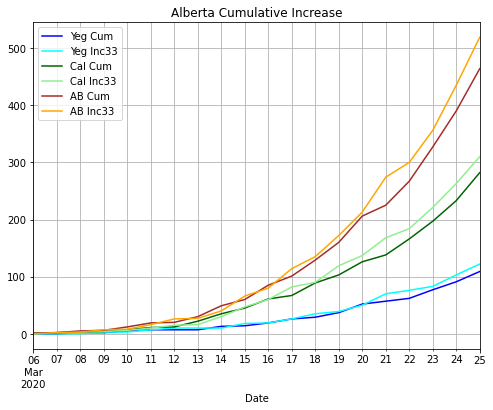

In [192]:
fig, ax = plt.subplots(figsize=(8,6))
covid.groupby(['Zone']).get_group('Edmonton').plot(y='cumsum', 
                                                   x='Date', 
                                                   ax=ax,
                                                   c='blue',
                                                   label='Yeg Cum')
covid.groupby(['Zone']).get_group('Edmonton').plot(y='inc33', 
                                                   x='Date', 
                                                   ax=ax, 
                                                   c='cyan',
                                                   label='Yeg Inc33')
covid.groupby(['Zone']).get_group('Calgary').plot(y='cumsum', 
                                                   x='Date', 
                                                   ax=ax,
                                                   c='darkgreen',
                                                   label='Cal Cum')
covid.groupby(['Zone']).get_group('Calgary').plot(y='inc33', 
                                                   x='Date', 
                                                   ax=ax, 
                                                   c='lightgreen',
                                                   label='Cal Inc33')
totals.plot(y='cumsum', x='Date', ax=ax, c='brown', label='AB Cum')
totals.plot(y='inc33', x='Date', ax=ax, c='orange', label='AB Inc33')
ax.grid(which='both')
ax.set_title('Alberta Cumulative Increase')
fig.savefig('AlbertaCumIncrease.png', bbox_inches='tight')

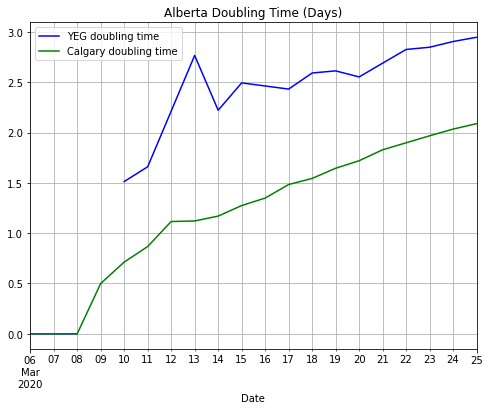

In [199]:
fig, ax = plt.subplots(figsize=(8,6))
covid.groupby(['Zone']).get_group('Edmonton').plot(y='dtime', 
                                                   x='Date', 
                                                   ax=ax, 
                                                   label="YEG doubling time",
                                                   color='blue')
covid.groupby(['Zone']).get_group('Calgary').plot(y='dtime', 
                                                  x='Date', 
                                                  ax=ax, 
                                                  label="Calgary doubling time",
                                                  color='green')
# totals.plot(y='dtime', x='Date',  ax=ax, 
#             label="Alberta doubling time", color='cyan')

ax.grid(which='both')
ax.set_title('Alberta Doubling Time (Days)')
fig.savefig('AlbertaDTimeIncrease.png', bbox_inches='tight')

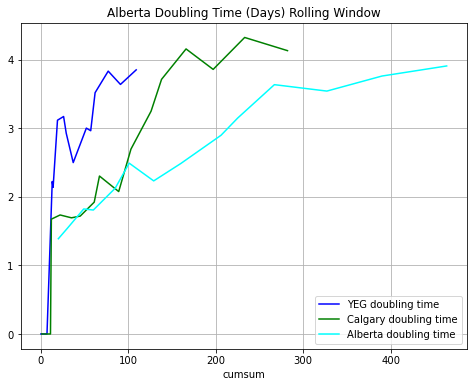

In [202]:
fig, ax = plt.subplots(figsize=(8,6))
covid.groupby(['Zone']).get_group('Edmonton').plot(y='dtime_rw', 
                                                   x='cumsum', 
                                                   ax=ax, 
                                                   label="YEG doubling time",
                                                   color='blue')
covid.groupby(['Zone']).get_group('Calgary').plot(y='dtime_rw', 
                                                  x='cumsum', 
                                                  ax=ax, 
                                                  label="Calgary doubling time",
                                                  color='green')
totals.plot(y='dtime_rw', x='cumsum',  ax=ax, 
            label="Alberta doubling time", color='cyan')

ax.grid(which='both')
ax.set_title('Alberta Doubling Time (Days) Rolling Window')
fig.savefig('AlbertaDTimeIncreaseRW_byCaseCount.png', bbox_inches='tight')

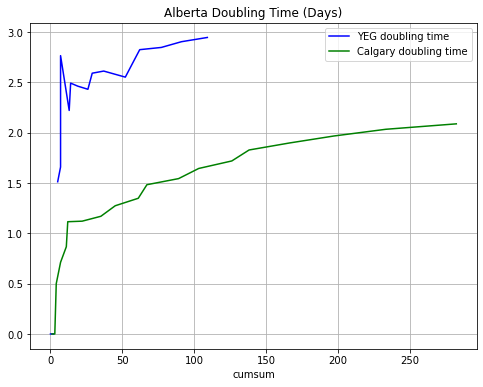

In [201]:
fig, ax = plt.subplots(figsize=(8,6))
covid.groupby(['Zone']).get_group('Edmonton').plot(y='dtime', 
                                                   x='cumsum', 
                                                   ax=ax, 
                                                   label="YEG doubling time",
                                                   color='blue')
covid.groupby(['Zone']).get_group('Calgary').plot(y='dtime', 
                                                  x='cumsum', 
                                                  ax=ax, 
                                                  label="Calgary doubling time",
                                                  color='green')
# totals.plot(y='dtime', x='Date',  ax=ax, 
#             label="Alberta doubling time", color='cyan')

ax.grid(which='both')
ax.set_title('Alberta Doubling Time (Days)')
fig.savefig('AlbertaDTimeIncrease_byCaseCount.png', bbox_inches='tight')

In [195]:
covid.to_csv('covid_analysis.csv')